In [1]:
# imports, including functions provided with the starter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('..')

from groupXY_functions import *

In [2]:
# week11-2_features.pdf, slide 11
def get_compactness(area, perimeter):
    return perimeter**2 / (4 * np.pi * area)

# Return smallest and largest y, smallest and largest y that contains a white pixel
def get_extremes(image):
    non_zeros = np.nonzero(image)
    return min(non_zeros[1]), max(non_zeros[1]), min(non_zeros[0]), max(non_zeros[0])

# Returns assymetry score of an image in vertical and horizontal axises.
# 0 is a perfect circle, 1 has all the quarters of an image completely different
def assymetry_score(image):
    min_x, max_x, min_y, max_y = get_extremes(image)
    width = max_x - min_x + 1
    height = max_y - min_y + 1
    print(width, height)
    image_cropped = image[min_y:max_y+1, min_x:max_x+1]
    if width % 2:
        # halves need to be the same size to compare them
        left_half = image_cropped[:, 0:width//2+1]
    else:
        left_half = image_cropped[:, 0:width//2]
    right_half = np.flip(image_cropped[:, width//2:], 1)
    if height % 2:
        top_half = image_cropped[0:height//2+1, :]
    else:
        top_half = image_cropped[0:height//2, :]
    bottom_half = np.flip(image_cropped[height//2:, :], 0)
    hor_diff = np.where(left_half != right_half, 1, 0)
    ver_diff = np.where(top_half != bottom_half, 1, 0)
    return (np.sum(hor_diff) + np.sum(ver_diff)) / width / height

In [3]:
# Import a data frame with file names and associated diseases
df = pd.read_csv('data/example_ground_truth.csv')

In [4]:
# TODO: iterate over every element, put in the data frame
data_folder = 'data/'
im = plt.imread(data_folder + 'example_image/ISIC_0001769.jpg')
mask = plt.imread(data_folder + 'example_segmentation/ISIC_0001769_segmentation.png')

688 521
0.19465305985805473


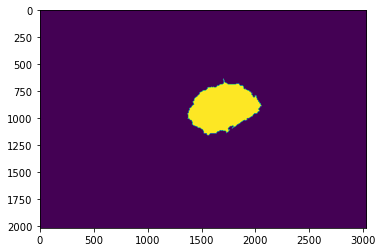

In [5]:
plt.imshow(mask)
print(assymetry_score(mask))